In [1]:
### addtiional info: https://www.gpxz.io/blog/gpx-file-to-pandas
#### https://towardsdatascience.com/parsing-fitness-tracker-data-with-python-a59e7dc17418

import gpxpy
import gpxpy.gpx
import geopy.distance
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from typing import Dict, Union
from datetime import datetime
from numpy_ext import rolling_apply
import numpy as np

# Apply the default theme
sns.set_theme()

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [2]:
# Load gpx
gpx_path = '2022-09-20.gpx'
with open(gpx_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)
track = gpx.tracks[0]
segment = track.segments[0]

In [3]:
# The XML namespaces used by the GPX file for extensions, used when parsing the extensions
NAMESPACES = {'garmin_tpe': 'http://www.garmin.com/xmlschemas/TrackPointExtension/v1'}

# The names of the columns we will use in our DataFrame
COLUMN_NAMES = ['latitude', 'longitude', 'elevation', 'time', 'heart_rate', ]

def get_gpx_point_data(point: gpxpy.gpx.GPXTrackPoint) -> Dict[str, Union[float, datetime, int]]:
        """Return a tuple containing some key data about `point`."""
        
        data = {
            'latitude': point.latitude,
            'longitude': point.longitude,
            'elevation': point.elevation,
            'time': point.time}
    
        # Parse extensions for heart rate and cadence data, if available
        elem = point.extensions[0]  # Assuming we know there is only one extension
        try:
            data['heart_rate'] = int(elem.find('garmin_tpe:hr', NAMESPACES).text)
        except AttributeError:
            # "text" attribute not found, so data not available
            pass
            
        return data

In [4]:
segment = gpx.tracks[0].segments[0]  # Assuming we know that there is only one track and one segment
data = [get_gpx_point_data(point) for point in segment.points]
df = pd.DataFrame(data, columns=COLUMN_NAMES)

In [5]:
# Cumulative distance.
coords = [(p.latitude, p.longitude) for p in df.itertuples()]
df['distance'] = [0] + [geopy.distance.distance(from_, to).m for from_, to in zip(coords[:-1], coords[1:])]
df['cumulative_distance'] = df.distance.cumsum()
df['cumulative_miles'] = 0.000621371 * df['cumulative_distance']

In [6]:
# the below uses the speed embedded in the data, calling it realspeed

ser = pd.array([0], dtype=float)

for x in range(0,len(df)-1):
    speed = segment.get_speed(x)
    ser = np.append(ser,[speed])

df['speed_in_meters'] = pd.Series(ser)
df['realspeed'] = df['speed_in_meters'] * 2.23694 # convert to mph
df['rolling_realspeed'] = df['realspeed'].rolling(10).mean() # using rolling average to smooth out
df

,latitude,longitude,elevation,time,heart_rate,distance,cumulative_distance,cumulative_miles,speed_in_meters,realspeed,rolling_realspeed
0,40.671827,-73.963422,49.4,2022-09-20 12:39:56+00:00,131,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
1,40.672172,-73.963945,50.8,2022-09-20 12:40:01+00:00,132,58.507972,58.507972,0.036355,11.707758,26.189551,NaN
2,40.672169,-73.963976,50.9,2022-09-20 12:40:02+00:00,132,2.642157,61.150130,0.037997,7.174089,16.048007,NaN
3,40.672212,-73.964057,51.0,2022-09-20 12:40:03+00:00,133,8.348917,69.499047,0.043185,5.494341,12.290511,NaN
4,40.672224,-73.964106,51.3,2022-09-20 12:40:04+00:00,133,4.352014,73.851061,0.045889,6.352983,14.211242,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3032,40.671884,-73.962569,47.5,2022-09-20 13:31:02+00:00,160,1.507995,23545.412012,14.630436,2.682427,6.000427,3.968931
3033,40.671875,-73.962525,47.5,2022-09-20 13:31:03+00:00,161,3.852153,23549.264165,14.632830,2.678992,5.992744,3.689753
3034,40.671864,-73.962476,47.5,2022-09-20 13:31:04+00:00,160,4.319326,23553.583492,14.635514,4.081100,9.129175,3.998787
3035,40.671858,-73.962426,47.4,2022-09-20 13:31:05+00:00,160,4.279736,23557.863228,14.638173,4.294870,9.607367,4.593059


In [7]:
# get summary info
print("Activity Name:", track.name)
print("Min Elevation (ft):", "%.2f" % round(gpx.get_elevation_extremes()[0]*3.28084, 2))
print("Max Elevation (ft):", "%.2f" % round(gpx.get_elevation_extremes()[1]*3.28084, 2))
print("Moving Time (min):", "%.2f" % round(segment.get_moving_data()[0]/60, 2))
print("Stopped Time (min):", "%.2f" % round(segment.get_moving_data()[1]/60, 2))
print("Moving Distance (miles):", "%.2f" % round(segment.get_moving_data()[2]*0.000621371, 2))
print("Stopped Distance (miles):", "%.2f" % round(segment.get_moving_data()[3]*0.00062137, 2))
print("Max Speed (mph):", "%.2f" % round(df['rolling_realspeed'].max(), 2))
print("Avg Speed (mph):", "%.2f" % round(df['rolling_realspeed'].mean(), 2))
print("Max HR:", "%.2f" % round(df['heart_rate'].max(), 2))
print("Avg HR:", "%.2f" % round(df['heart_rate'].mean(), 2))

Activity Name: Morning Ride
Min Elevation (ft): 65.29
Max Elevation (ft): 170.60
Moving Time (min): 50.68
Stopped Time (min): 0.47
Moving Distance (miles): 14.66
Stopped Distance (miles): 0.00
Max Speed (mph): 31.42
Avg Speed (mph): 17.35
Max HR: 171.00
Avg HR: 155.44


<Figure size 960x480 with 0 Axes>

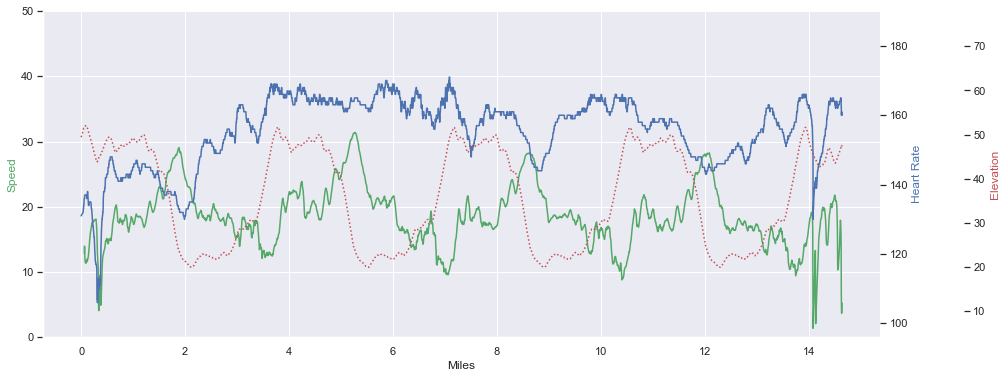

In [8]:
# graph speed

figure(figsize=(12, 6), dpi=80)

x = df.cumulative_miles
y1 = df.rolling_realspeed
y2 = df.heart_rate
y3 = df.elevation

fig, ax1 = plt.subplots()
fig.set_size_inches(15,6)

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(("axes", 1.1))

ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')
ax3.plot(x, y3, 'r:')

ax1.set_xlabel('Miles')
ax1.set_ylabel('Speed', color='g')
ax2.set_ylabel('Heart Rate', color='b')
ax3.set_ylabel('Elevation', color='r')

ax2.grid(False)
ax3.grid(False)

ax1.set_ylim(0,50)
ax2.set_ylim(df['heart_rate'].min()-10,190)
ax3.set_ylim(gpx.get_elevation_extremes()[0]/5,gpx.get_elevation_extremes()[1]*1.5)

plt.show()

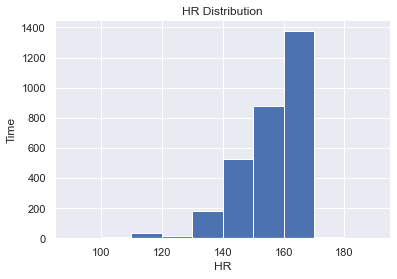

In [30]:
# the histogram of the data
n, bins, patches = plt.hist(df['heart_rate'], 10, range=(90,190))

plt.xlabel('HR')
plt.ylabel('Time')
plt.title('HR Distribution')
plt.show()

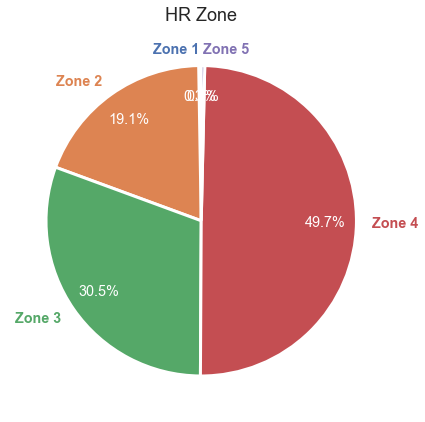

In [10]:
hr_count, division = np.histogram(df['heart_rate'], bins = [0, 109,147,159,170,200])
hr_count = pd.DataFrame(hr_count)
x = hr_count[0]

labels = ['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5']

fig, ax = plt.subplots(figsize=(6, 6))

patches, texts, pcts = ax.pie(
    x, labels=labels, pctdistance=0.8, # controls distance from center of %
    autopct='%.1f%%',
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'},
    startangle=90)
# For each wedge, set the corresponding text label color to the wedge's
# face color.
for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)
ax.set_title('HR Zone', fontsize=18)

plt.tight_layout()


In [11]:
hrdf = pd.DataFrame([labels,x]).T
hrdf[2] = hrdf[1]/hrdf[1].sum()*100
hrdf = hrdf.rename({0: 'Zone', 1: 'Seconds',2: 'Percent', }, axis='columns')
hrdf

,Zone,Seconds,Percent
0,Zone 1,8,0.263418
1,Zone 2,581,19.130721
2,Zone 3,927,30.523543
3,Zone 4,1510,49.720119
4,Zone 5,11,0.3622


<Figure size 960x480 with 0 Axes>

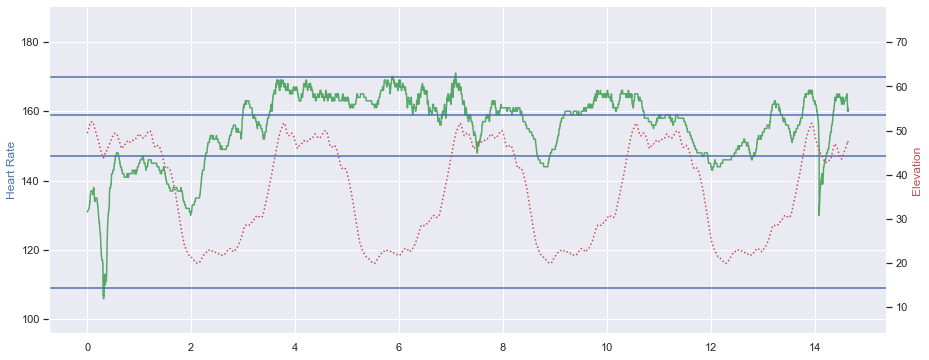

In [12]:
# Plot HR zones
figure(figsize=(12, 6), dpi=80)

x = df.cumulative_miles
y = df.heart_rate
y3 = df.elevation

fig, ax1 = plt.subplots()
fig.set_size_inches(15,6)

ax3 = ax1.twinx()
ax1.plot(x, y, 'g-')
ax3.plot(x, y3, 'r:')

ax1.set_ylabel('Heart Rate', color='b')
ax3.set_ylabel('Elevation', color='r')
ax1.set_ylim(df['heart_rate'].min()-10,190)
ax3.set_ylim(gpx.get_elevation_extremes()[0]/5,gpx.get_elevation_extremes()[1]*1.5)

ax3.grid(False)

ax1.axhline(y=109) # plot zone lines
ax1.axhline(y=147)
ax1.axhline(y=159)
ax1.axhline(y=170)

plt.show()

In [13]:
lat = str(df['latitude'][0])[0:7]
lon = str(df['longitude'][0])[0:8]
date = df['time'][0].strftime('%Y-%m-%d')

print(lat,lon,date)

40.6718 -73.9634 2022-09-20


In [14]:
# scrape weather for time of activity
import bs4
import requests

headers = {'User-Agent': 'Opera/9.80 (Windows NT 6.1; Win64; x64; Edition Next) Presto/2.12.388 Version/12.15',}
url = "https://darksky.net/details/%s,%s/%s/us12/en" % (lat,lon,date)
res = requests.get(url, headers=headers)
soup = bs4.BeautifulSoup(res.text, 'html.parser')

In [15]:
from datetime import datetime
import ast

dtime = df['time'][0]
dtimestamp = str(round(dtime.timestamp()))
print("Integer timestamp of first data point: ", dtimestamp)

Integer timestamp of first data point:  1663677596


In [16]:
# pull temp from soup using above timestamp

all_scripts = soup.find_all('script')
jsn = all_scripts[1].text[16:]
jsn = jsn.split(dtimestamp[0:5])[1]
jsn = "{" + jsn.split('visibility')[0][6:-2] + "}"

jsn = ast.literal_eval(jsn)
print("Weather Summary:", jsn.get("summary"))
print("Temperature:", jsn.get("temperature"))
print("Feels Like:", jsn.get("apparentTemperature"))
print("Humidity:", jsn.get("humidity"))
print("Windspeed:", jsn.get("windSpeed"))
print("Precip Intensity:", jsn.get("precipIntensity"))

Weather Summary: Clear
Temperature: 70.69
Feels Like: 71.55
Humidity: 0.87
Windspeed: 6.3
Precip Intensity: 0.0035


In [17]:
# add map

import folium

route_map = folium.Map(
    location=[lat, lon],
    zoom_start=13,
    tiles='CartoDBPositron',
    width=1024,
    height=600
)

coordinates = [tuple(x) for x in df[['latitude', 'longitude']].to_numpy()]
folium.PolyLine(coordinates, weight=6).add_to(route_map)

display(route_map)